In [1]:
import numpy as np
import pylab
from time import time
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from qiskit.opflow import I, X, Y, Z
from qiskit_ibm_runtime.options import Options, SimulatorOptions
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

service = QiskitRuntimeService()
device_backend=FakeNairobi()
device_backend = FakeBelem()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

#from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP


In [2]:
# Build a ZNE estimator
from zne import zne
from qiskit.primitives import Estimator, BackendEstimator
# Define fake backend
noisy_backend = device_backend

# Define Estimator with the fake backend
ZNEEstimator = zne(BackendEstimator)


In [3]:
# Define strategy
from zne import ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator, LinearExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier

# Define Extrapolator
extrapolator = PolynomialExtrapolator(degree=2)
# Define Amplifier
noise_amplifier = LocalFoldingAmplifier(gates_to_fold=2) 

# Define strategy
zne_strategy = ZNEStrategy(
    noise_factors=[1, 3, 5],
    noise_amplifier = noise_amplifier,
    extrapolator=extrapolator
)

In [4]:
# Apply strategy to ZNE Estimator
noisy_estimator_zne = ZNEEstimator(backend=noisy_backend, zne_strategy=zne_strategy)

In [5]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

In [6]:
H2_op

PauliSumOp(SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j]), coeff=1.0)

In [7]:
from qiskit.circuit.library import TwoLocal, EfficientSU2
ansatz_tl = TwoLocal(2, rotation_blocks="ry", entanglement_blocks="cz")
ansatz_eff = EfficientSU2(2, entanglement='full', reps=2, skip_final_rotation_layer=True).decompose()
ansatz_eff.draw(fold=300)

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├──■──
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├┤ X ├
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘

In [8]:
ansatz_tl.decompose().draw()

┌──────────┐   ┌──────────┐   ┌──────────┐   ┌──────────┐
q_0: ┤ Ry(θ[0]) ├─■─┤ Ry(θ[2]) ├─■─┤ Ry(θ[4]) ├─■─┤ Ry(θ[6]) ├
     ├──────────┤ │ ├──────────┤ │ ├──────────┤ │ ├──────────┤
q_1: ┤ Ry(θ[1]) ├─■─┤ Ry(θ[3]) ├─■─┤ Ry(θ[5]) ├─■─┤ Ry(θ[7]) ├
     └──────────┘   └──────────┘   └──────────┘   └──────────┘

In [9]:
from qiskit.algorithms import NumPyEigensolver
# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=1)
exact_result = exact_solver.compute_eigenvalues(H2_op)
print(exact_result.eigenvalues)


[-1.85727503]


In [10]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

In [11]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


In [12]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [13]:
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as Aer_Estimator

In [14]:
theta = [0, 1, 1, 2, 3, 5, 8, 1]
# Define instance of qiskit-terra's Estimator primitive
estimator = Aer_Estimator([ansatz_tl], [H2_op], backend_options={'method':'statevector'}, run_options={'shots':None}, approximation=True)
#estimator = noisy_estimator_zne.run([ansatz_tl], [H2_op])
# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_tl, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(H2_op)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': None,
    'eigenvalue': -1.8564526127036036,
    'optimal_circuit': None,
    'optimal_parameters': array([ 0.7531168 , -0.17601324,  1.47895533,  0.2360428 ,  0.30365442,
       -0.23041655,  0.54317941, -0.39586075]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 0.80


In [15]:
# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

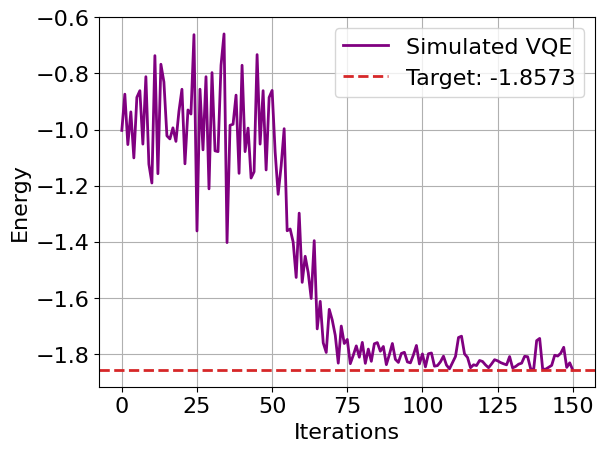

In [16]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [17]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -1.8573000000
Computed ground state energy: -1.8564526127
Relative error: 0.00045625


In [18]:
service = QiskitRuntimeService(channel='ibm_quantum')

backend = 'ibmq_belem'

est_options=Options(
    resilience_level=2,
    optimization_level=1
)

# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session, options=est_options)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_tl, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(H2_op)
end = time()
print(f'execution time (s): {end - start:.2f}')



execution time (s): 3118.32


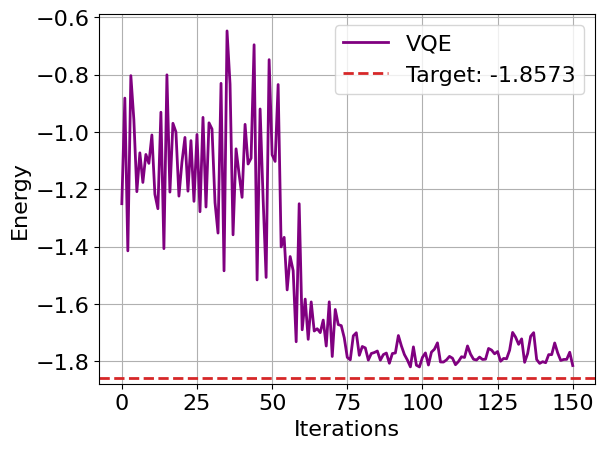

In [19]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [20]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

Expected ground state energy: -1.85730000
Computed ground state energy: -1.81528750
Relative error: 2.26202016 %
